In [34]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.neural_network import MLPClassifier  # or MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import joblib
import pandas as pd

In [32]:
df = pd.read_csv('../data/processed/calls_2025_06_07.csv')
df_final = df[['price', 'strike', 'T', 'impliedVolatility', 'midPrice']].copy()

# Rename columns for clarity
df_final.rename(columns={
    'price': 'S',  # Current stock price
    'strike': 'K',  # Strike price
    'T': 'T',  # Time to expiration in years
    'impliedVolatility': 'sigma',  # Volatility of the underlying stock
    'midPrice': 'call_price'  # Black-Scholes price of the call option
}, inplace=True)

In [35]:
INPUTS = df_final.columns.drop('call_price').tolist()
TARGET = 'call_price'

X = df_final[INPUTS]
y = df_final[TARGET]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
MLP_fit = joblib.load('../models/MLP_simple_vs_BS.pkl')
mlp = MLP_fit.best_estimator_['MLP']

In [ ]:
wts = mlp.coefs_
biases = mlp.intercepts_


In [14]:
layer_sizes = [mlp.coefs_[0].shape[0]] + [w.shape[1] for w in mlp.coefs_]
print(layer_sizes)

[4, 80, 1]


In [15]:
class TorchMLP(nn.Module):
    def __init__(self, layer_sizes, activation='tanh'):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes)-1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
        self.activation = activation

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
            if self.activation == 'relu':
                x = F.relu(x)
            elif self.activation == 'tanh':
                x = torch.tanh(x)
            elif self.activation == 'logistic':
                x = torch.sigmoid(x)
        x = self.layers[-1](x)
        return x

In [18]:
torch_model = TorchMLP(layer_sizes, activation='tanh')
torch_model.eval()

TorchMLP(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=80, bias=True)
    (1): Linear(in_features=80, out_features=1, bias=True)
  )
)

In [19]:
for i, layer in enumerate(torch_model.layers):
    W = mlp.coefs_[i].T  # sklearn tiene (in_features, out_features), torch (out_features, in_features)
    b = mlp.intercepts_[i]
    layer.weight.data = torch.from_numpy(W.astype(np.float32))
    layer.bias.data = torch.from_numpy(b.astype(np.float32))

In [55]:
pipe = MLP_fit.best_estimator_
scaler = pipe.named_steps['preprocessor'].named_transformers_['num'].named_steps['scaler']
X_train_scaled = scaler.transform(X_train)
X_tensor = torch.from_numpy(X_train_scaled.astype(np.float32))
y_pred_torch = torch_model(X_tensor).detach().numpy()

In [56]:
y_pred_sklearn = mlp.predict(X_train_scaled)

In [57]:
for i in range(len(y_pred_sklearn)):
    print(f"Sklearn: {y_pred_sklearn[i]:.6f}, Torch: {y_pred_torch[i][0]:.6f}, Diff: {y_pred_sklearn[i] - y_pred_torch[i][0]:.6f}")

Sklearn: 10.692650, Torch: 10.692612, Diff: 0.000038
Sklearn: -0.601534, Torch: -0.601486, Diff: -0.000047
Sklearn: -3.331207, Torch: -3.331192, Diff: -0.000015
Sklearn: 144.085476, Torch: 144.085464, Diff: 0.000012
Sklearn: 6.509368, Torch: 6.509384, Diff: -0.000016
Sklearn: 8.966965, Torch: 8.966965, Diff: 0.000000
Sklearn: -0.640023, Torch: -0.640030, Diff: 0.000007
Sklearn: -5.043130, Torch: -5.043137, Diff: 0.000006
Sklearn: 59.338132, Torch: 59.338181, Diff: -0.000048
Sklearn: 4.480155, Torch: 4.480209, Diff: -0.000054
Sklearn: 67.622115, Torch: 67.622025, Diff: 0.000090
Sklearn: -0.679772, Torch: -0.679794, Diff: 0.000023
Sklearn: 9.013266, Torch: 9.013199, Diff: 0.000067
Sklearn: 692.177773, Torch: 692.177673, Diff: 0.000099
Sklearn: 12.854579, Torch: 12.854568, Diff: 0.000011
Sklearn: 5.082436, Torch: 5.082413, Diff: 0.000023
Sklearn: 57.488877, Torch: 57.488876, Diff: 0.000001
Sklearn: 8.273860, Torch: 8.273911, Diff: -0.000050
Sklearn: 6.683045, Torch: 6.683060, Diff: -0.000

In [69]:
# Suponemos: X_tensor es de tamaño [N, input_dim], por ejemplo un único punto:
x_sample = X_tensor[0].unsqueeze(0)  # [1, input_dim]
x_sample.requires_grad_(True)

# Forward pass
y_pred = torch_model(x_sample)

# Backward para gradiente
y_pred.backward()

# Primera derivada (gradientes respecto a inputs)
first_derivative = x_sample.grad.detach().numpy()

print("Primera derivada (torch):", first_derivative)

Primera derivada (torch): [[ 203.61967   -161.8725      35.024994     6.3873596]]


In [75]:
X_tensor_unsqueeze = X_tensor.unsqueeze(0)  # [1, N, input_dim]
X_tensor_unsqueeze.requires_grad_(True)
y_pred_unsqueeze = torch_model(X_tensor_unsqueeze)
y_pred_unsqueeze.backward(torch.ones_like(y_pred_unsqueeze))

first_derivative_unsqueeze = X_tensor_unsqueeze.grad.detach().numpy()
# Convert to df
first_derivative_df_torch = pd.DataFrame(first_derivative_unsqueeze[0], columns=INPUTS)
first_derivative_df_torch

S           K           T       sigma
0       203.619659 -161.872528   35.024998    6.387342
1       204.739380  -66.805176  200.121292  -39.388607
2       199.183090  -97.764526   13.084779  -31.160492
3       332.691010 -189.963531   49.863281  254.187180
4       346.108643 -296.159393    6.498750   22.771702
...            ...         ...         ...         ...
109439  557.470581 -436.431915   28.313517  134.701889
109440  236.244171 -157.030563  203.562256   80.480042
109441  182.949783 -119.593468    0.885056   16.412930
109442  281.623657 -184.094101  102.892967   43.324886
109443  211.757263 -165.944122   18.339766   74.432800

[109444 rows x 4 columns]

In [62]:
# Comparar con la primera derivada de jacobian mlp
from neuralsens import partial_derivatives as ns
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS)
X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=[TARGET])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y,)

/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/neuralsens/partial_derivatives.py:1749: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


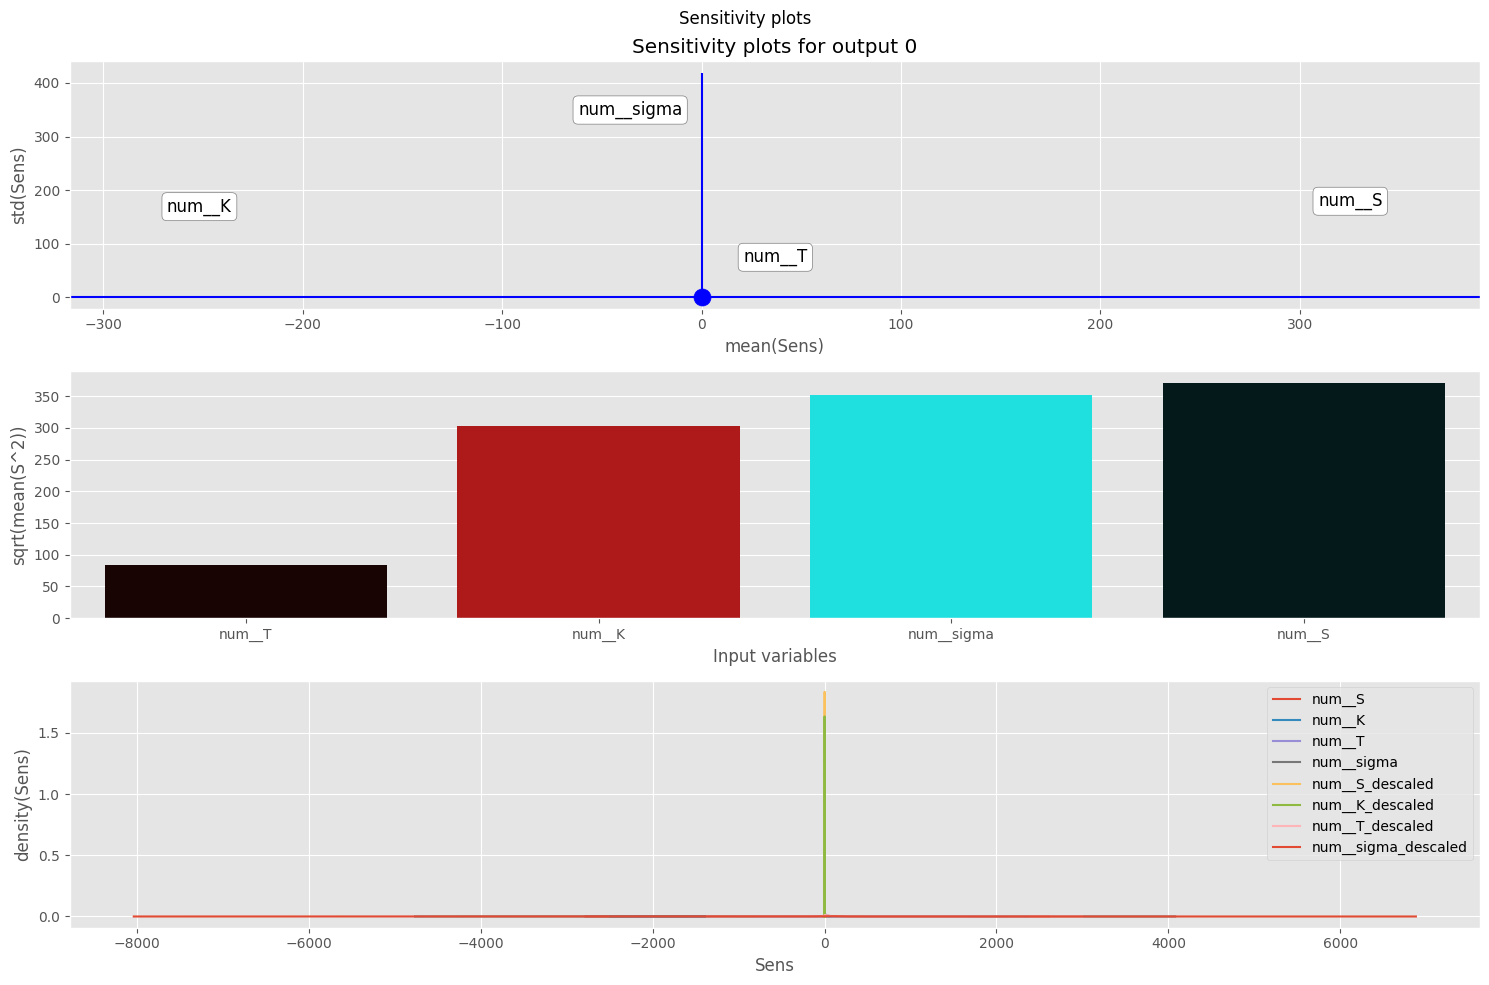

In [87]:
sensmlp.plot()

In [88]:
hessianmlp = ns.hessian_mlp(wts, bias, actfunc, X, y, sens_end_layer=sens_end_layer,
                            sens_end_input=sens_end_input,
                            sens_origin_layer=sens_origin_layer,
                            sens_origin_input=sens_origin_input)

TypeError: tanh(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [76]:
df_partDeriv_sk = sensmlp.raw_sens[0]
scaler = MLP_fit.best_estimator_['preprocessor'].transformers_[0][1].named_steps['scaler']
scales = scaler.scale_

# Supongamos que las columnas del neuralsense son:
# ['num__S', 'num__K', 'num__T', 'num__sigma']
columns = ['num__S', 'num__K', 'num__T', 'num__sigma']

# Desescalamos las derivadas:
for i, col in enumerate(columns):
    df_partDeriv_sk[col + '_descaled'] = df_partDeriv_sk[col] / scales[i]

In [79]:
df_partDeriv_sk

num__S      num__K      num__T  num__sigma  num__S_descaled  \
0       203.619707 -161.872469   35.025026    6.387379         0.328598   
1       204.739435  -66.805238  200.121530  -39.388661         0.330405   
2       199.183086  -97.764519   13.084808  -31.160425         0.321438   
3       332.691018 -189.963534   49.863294  254.187116         0.536891   
4       346.108650 -296.159507    6.498758   22.771691         0.558544   
...            ...         ...         ...         ...              ...   
109439  557.470674 -436.431986   28.313519  134.701887         0.899636   
109440  236.244093 -157.030451  203.562257   80.479959         0.381247   
109441  182.949724 -119.593475    0.885083   16.412884         0.295241   
109442  281.623618 -184.094043  102.893019   43.325021         0.454479   
109443  211.757296 -165.944130   18.339784   74.432858         0.341730   

        num__K_descaled  num__T_descaled  num__sigma_descaled  
0             -0.270595        62.127375            10.774468  
1             -0.111675       354.975476           -66.442252  
2             -0.163428        23.209826           -52.562559  
3             -0.317553        88.447487           428.772239  
4             -0.495076        11.527493            38.412131  
...                 ...              ...                  ...  
109439        -0.729563        50.222506           227.220130  
109440        -0.262501       361.078635           135.756575  
109441        -0.199919         1.569959            27.685860  
109442        -0.307742       182.511589            73.082249  
109443        -0.277401        32.531100           125.556100  

[109444 rows x 8 columns]

In [80]:
first_derivative_df_torch

S           K           T       sigma
0       203.619659 -161.872528   35.024998    6.387342
1       204.739380  -66.805176  200.121292  -39.388607
2       199.183090  -97.764526   13.084779  -31.160492
3       332.691010 -189.963531   49.863281  254.187180
4       346.108643 -296.159393    6.498750   22.771702
...            ...         ...         ...         ...
109439  557.470581 -436.431915   28.313517  134.701889
109440  236.244171 -157.030563  203.562256   80.480042
109441  182.949783 -119.593468    0.885056   16.412930
109442  281.623657 -184.094101  102.892967   43.324886
109443  211.757263 -165.944122   18.339766   74.432800

[109444 rows x 4 columns]

In [81]:
from torch.autograd.functional import hessian

# Definimos función escalar sobre la que calcular Hessiana
def model_scalar_fn(x):
    return torch_model(x.unsqueeze(0)).squeeze()

# Hessiana en un punto
hess = hessian(model_scalar_fn, x_sample.squeeze())

print("Hessiana (torch):")
print(hess.detach().numpy())

Hessiana (torch):
[[ 1076.618    -1148.2407     -60.60094   -211.01843 ]
 [-1148.2407    1030.48       124.92453    216.41096 ]
 [  -60.600945   124.92454   -111.53131    -29.352364]
 [ -211.0184     216.41095    -29.35235  -1281.5945  ]]


In [86]:
scales = scaler.scale_

H_scaled = hess.detach().cpu().numpy()  # Convertimos a numpy y hacemos copia

# Creamos el denominador 1 / (s_i * s_j)
scale_matrix = np.outer(scales, scales)  # shape (4,4)
inv_scale_matrix = 1.0 / scale_matrix
H_real = H_scaled * inv_scale_matrix

print("Hessiana desescalada (espacio real):")
print(H_real)

Hessiana desescalada (espacio real):
[[ 2.80382980e-03 -3.09759271e-03 -1.73471805e-01 -5.74431854e-01]
 [-3.09759271e-03  2.87960090e-03  3.70423585e-01  6.10237310e-01]
 [-1.73471816e-01  3.70423607e-01 -3.50918187e+02 -8.78255217e+01]
 [-5.74431771e-01  6.10237267e-01 -8.78254817e+01 -3.64667348e+03]]
